### **Columbia University**
### **ECBM E4040 Neural Networks and Deep Learning. Fall 2021.**

## **Task 2: RNN application -- Tweet Sentiment Analysis**

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimenssionality redution. 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data


In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## **Part 1 LSTM Encoder**

**TODO**: Create a single-layer LSTM network to classify tweets. Use one hot encoding to represent each word in the tweet. Set LSTM units to 100. Use Adam optimizer and set batch size to 64.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional). 

(tf.one_hot and Keras functional API may be useful).

In [3]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################

import tensorflow.keras as keras
import tensorflow.keras.layers as layers

train_onehot = tf.one_hot(train_tweets, 1000) # (60000,20,1000)
test_onehot = tf.one_hot(test_tweets, 1000) # (1000,20,1000)

model_1 = tf.keras.Sequential([
    layers.LSTM(100, input_dim = 1000),
    layers.Dense(1)
])

model_1.summary()

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      optimizer='adam',
      metrics=['accuracy'])

history_LSTM = model_1.fit(train_onehot, train_labels, batch_size=64, epochs=15)

###################################################
# END TODO                                        #
###################################################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               440400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 440,501
Trainable params: 440,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
938/938 [==============================] - 50s 51ms/step - loss: 0.5893 - accuracy: 0.6447
Epoch 2/15
938/938 [==============================] - 48s 51ms/step - loss: 0.5127 - accuracy: 0.7274
Epoch 3/15
938/938 [==============================] - 48s 51ms/step - loss: 0.4982 - accuracy: 0.7399
Epoch 4/15
938/938 [==============================] - 47s 51ms/step - loss: 0.4855 - accuracy: 0.7466
Epoch 5/15
938/938 [==============================] - 48s 52ms/step - loss: 0.4788 - accuracy: 0.7497
Ep

## **Part 2: Embedding Lookup layer**

**Define an embedding layer**

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling.

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

**TODO**: Define a similar model as above with one change. Use an Embedding layer instead of one hot embedding. Also, write a custom training loop to train the model instead of using model.fit(). Writing a custom loop gives you complete control over how the model is trained. Refer to the link below.

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

Report loss and accuracy for training and validation after each epoch. Also, display the loss value after every 400 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?


Solution:

In [4]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################


model_2 = tf.keras.Sequential()
model_2.add(layers.Embedding(np.max(train_tweets)+1, 64, input_length = 20, name = 'embedding'))
model_2.add(layers.LSTM(100))
model_2.add(layers.Dense(1, activation = 'sigmoid'))

loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 1e-3, decay = 1e-5)
epochs = 10
batch_size = 64

iterations = np.ceil(len(train_tweets)/batch_size).astype('int32')
step = 0


for epoch in range (epochs):
    print("\nStart of epoch %d" % (epoch,))
    index = np.arange(len(train_tweets))
    np.random.shuffle(index)
    sum_loss = 0
    sum_acc = 0
    
    for i in range (iterations):
        index_batch = index[i*batch_size:(i+1)*batch_size]
        X_batch = train_tweets[index_batch,...]
        y_batch = train_labels[index_batch, np.newaxis]
        with tf.GradientTape() as tape:
            y_pred = model_2(X_batch)
            loss = loss_function(y_batch, y_pred)
            accuracy = np.mean(y_batch == np.round(y_pred))
            
            gradients = tape.gradient(loss, model_2.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model_2.trainable_weights))
            sum_loss += loss
            sum_acc += accuracy
        step += 1
        if step == 400:
            print("Current loss of training: {}".format(loss))
            step = 0
    average_loss = sum_loss/ iterations
    average_acc = sum_acc/ iterations
    print("Training loss - {:.4f}, Training accuracy - {:.4f}".format(average_loss, average_acc))
    
    y_pred_t = model_2(test_tweets)
    y_test = test_labels[:,np.newaxis]
    loss_t = loss_function(y_test,y_pred_t)
    acc_t = np.mean(y_test == np.round(y_pred_t))
    print("Test loss - {:.4f}, Test accuracy - {:.4f}".format(loss_t, acc_t))


###################################################
# END TODO                                        #
###################################################


Start of epoch 0
Current loss of training: 0.49504563212394714
Current loss of training: 0.433331161737442
Training loss - 0.5300, Training accuracy - 0.7318
Test loss - 0.5001, Test accuracy - 0.7630

Start of epoch 1
Current loss of training: 0.5511115789413452
Current loss of training: 0.534947395324707
Training loss - 0.4590, Training accuracy - 0.7872
Test loss - 0.5029, Test accuracy - 0.7710

Start of epoch 2
Current loss of training: 0.3989056348800659
Current loss of training: 0.42975783348083496
Current loss of training: 0.4777466952800751
Training loss - 0.4313, Training accuracy - 0.8006
Test loss - 0.5004, Test accuracy - 0.7670

Start of epoch 3
Current loss of training: 0.5002090930938721
Current loss of training: 0.43928197026252747
Training loss - 0.4043, Training accuracy - 0.8149
Test loss - 0.5385, Test accuracy - 0.7580

Start of epoch 4
Current loss of training: 0.5521948933601379
Current loss of training: 0.37663260102272034
Training loss - 0.3748, Training accu

## **TODO:**  **Visualize word vectors via tSNE**

First, you need to retrieve embedding matrix from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector.

And then, you should visualize some interesting word pairs in 2D panel. You may find scatter function in matplotlib.pyplot useful.

Hint: You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.

In [3]:
# load pre-trained word2vec embeddings
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model = gensim.models.KeyedVectors.load_word2vec_format('/home/ecbm4040/e4040-2021fall-assign3-yz3922/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [6]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]

keys = female_male + country_capital
print(keys)

['men', 'women', 'king', 'queen', 'spain', 'madrid', 'italy', 'rome', 'japan', 'tokyo']


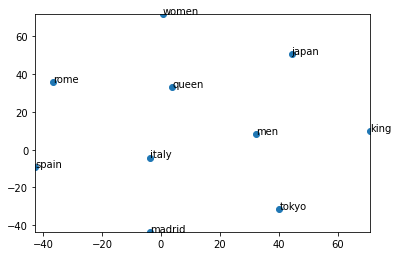

In [9]:
###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################

def TSNE_visualize(model, keys):
    
    arr = np.empty((0,300), dtype='f')
    key_labels = keys
    for key in keys:
        word_vector = model[key]
        arr = np.append(arr, np.array([word_vector]), axis=0)
        
    # tsne coords
    tsne = TSNE(n_components=2, random_state=0)
    Y = tsne.fit_transform(arr)

    # display scatter plot
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(word_labels, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(Y[:, 0].min()+0.00005, Y[:, 0].max()+0.00005)
    plt.ylim(Y[:, 1].min()+0.00005, Y[:, 1].max()+0.00005)
    plt.show()
    
TSNE_visualize(model,keys)
###################################################
# END TODO                                        #
###################################################